In [69]:
#TO DOs
#Date formatting in charts
# maybe add chart with fx.close, fx.close times slippage for v3, curve v2 twoPool, curve v2 three Pool


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

fx = pd.read_csv('CHFEUR=short.csv')
fx['Date'] = pd.to_datetime(fx['Date'])

sx = pd.read_csv('CHFSGD=short.csv')
sx['Date'] = pd.to_datetime(fx['Date'])

#fx.Close[0]


In [70]:
#!/usr/bin/env python3
import json

A_MULTIPLIER = 10000


def geometric_mean(x):
    N = len(x)
    x = sorted(x, reverse=True)  # Presort - good for convergence
    D = x[0]
    for i in range(255):
        D_prev = D
        tmp = 10 ** 18
        for _x in x:
            tmp = tmp * _x // D
        D = D * ((N - 1) * 10**18 + tmp) // (N * 10**18)
        diff = abs(D - D_prev)
        if diff <= 1 or diff * 10**18 < D:
            return D
    # print(x)
    raise ValueError("Did not converge")


def reduction_coefficient(x, gamma):
    N = len(x)
    x_prod = 10**18
    K = 10**18
    S = sum(x)
    for x_i in x:
        x_prod = x_prod * x_i // 10**18
        K = K * N * x_i // S
    if gamma > 0:
        K = gamma * 10**18 // (gamma + 10**18 - K)
    return K


def newton_D(A, gamma, x, D0):
    D = D0
    i = 0

    S = sum(x)
    x = sorted(x, reverse=True)
    N = len(x)

    for i in range(255):
        D_prev = D

        K0 = 10**18
        for _x in x:
            K0 = K0 * _x * N // D

        _g1k0 = abs(gamma + 10**18 - K0)

        # D / (A * N**N) * _g1k0**2 / gamma**2
        mul1 = 10**18 * D // gamma * _g1k0 // gamma * _g1k0 * A_MULTIPLIER // A

        # 2*N*K0 / _g1k0
        mul2 = (2 * 10**18) * N * K0 // _g1k0

        neg_fprime = (S + S * mul2 // 10**18) + mul1 * N // K0 - mul2 * D // 10**18
        assert neg_fprime > 0  # Python only: -f' > 0

        # D -= f / fprime
        D = (D * neg_fprime + D * S - D**2) // neg_fprime - D * (mul1 // neg_fprime) // 10**18 * (10**18 - K0) // K0

        if D < 0:
            D = -D // 2
        if abs(D - D_prev) <= max(100, D // 10**14):
            return D

    raise ValueError("Did not converge")


def newton_y(A, gamma, x, D, i):
    N = len(x)

    y = D // N
    K0_i = 10**18
    S_i = 0
    x_sorted = sorted(_x for j, _x in enumerate(x) if j != i)
    convergence_limit = max(max(x_sorted) // 10**14, D // 10**14, 100)
    for _x in x_sorted:
        y = y * D // (_x * N)  # Small _x first
        S_i += _x
    for _x in x_sorted[::-1]:
        K0_i = K0_i * _x * N // D  # Large _x first

    for j in range(255):
        y_prev = y

        K0 = K0_i * y * N // D
        S = S_i + y

        _g1k0 = abs(gamma + 10**18 - K0)

        # D / (A * N**N) * _g1k0**2 / gamma**2
        mul1 = 10**18 * D // gamma * _g1k0 // gamma * _g1k0 * A_MULTIPLIER // A

        # 2*K0 / _g1k0
        mul2 = 10**18 + (2 * 10**18) * K0 // _g1k0

        yfprime = (10**18 * y + S * mul2 + mul1 - D * mul2)
        fprime = yfprime // y
        assert fprime > 0  # Python only: f' > 0

        # y -= f / f_prime;  y = (y * fprime - f) / fprime
        y = (yfprime + 10**18 * D - 10**18 * S) // fprime + mul1 // fprime * (10**18 - K0) // K0

        # if j > 100:  # Just logging when doesn't converge
        #     print(j, y, D, x)
        if y < 0 or fprime < 0:
            y = y_prev // 2
        if abs(y - y_prev) <= max(convergence_limit, y // 10**14):
            return y

    raise Exception("Did not converge")


def solve_x(A, gamma, x, D, i):
    return newton_y(A, gamma, x, D, i)


def solve_D(A, gamma, x):
    D0 = len(x) * geometric_mean(x)  # <- fuzz to make sure it's ok XXX
    return newton_D(A, gamma, x, D0)


class Curve:
    def __init__(self, A, gamma, D, n, p=None):
        self.A = A
        self.gamma = gamma
        self.n = n
        if p:
            self.p = p
        else:
            self.p = [10 ** 18] * n
        self.x = [D // n * 10**18 // self.p[i] for i in range(n)]

    def xp(self):
        return [x * p // 10 ** 18 for x, p in zip(self.x, self.p)]

    def D(self):
        xp = self.xp()
        if any(x <= 0 for x in xp):
            raise ValueError
        return solve_D(self.A, self.gamma, xp)

    def y(self, x, i, j):
        xp = self.xp()
        xp[i] = x * self.p[i] // 10 ** 18
        yp = solve_x(self.A, self.gamma, xp, self.D(), j)
        return yp * 10**18 // self.p[j]


def get_data(fname):
    with open('download/{0}-1m.json'.format(fname), 'r') as f:
        return [{'open': float(t[1]), 'high': float(t[2]), 'low': float(t[3]),
                 'close': float(t[4]), 't': t[0] // 1000, 'volume': float(t[5])}
                for t in json.load(f)]


def get_all():
    # 0 - usdt
    # 1 - btc
    # 2 - eth
    out = []
    all_trades = {name: get_data(name) for name in ["btcusdt", "ethusdt", "ethbtc"]}
    min_time = max(t[0]['t'] for t in all_trades.values())
    max_time = min(t[-1]['t'] for t in all_trades.values())
    for name, pair in [("btcusdt", (0, 1)),
                       ("ethusdt", (0, 2)),
                       ("ethbtc", (1, 2))]:
        trades = all_trades[name]
        for trade in trades:
            if trade['t'] >= min_time and trade['t'] <= max_time:
                trade['pair'] = pair
                out.append((trade['t'] + sum(pair) * 15, trade))
    out = sorted(out)
    return [i[1] for i in out]


class Trader:
    def __init__(self, A, gamma, D, n, p0, mid_fee=1e-3, out_fee=3e-3, allowed_extra_profit=2 * 10**13, fee_gamma=None,
                 adjustment_step=0.003, ma_half_time=500, log=True):
        # allowed_extra_profit is actually not used
        self.p0 = p0[:]
        self.price_oracle = self.p0[:]
        self.last_price = self.p0[:]
        self.curve = Curve(A, gamma, D, n, p=p0[:])
        self.dx = int(D * 1e-8)
        self.mid_fee = int(mid_fee * 1e10)
        self.out_fee = int(out_fee * 1e10)
        self.D0 = self.curve.D()
        self.xcp_0 = self.get_xcp()
        self.xcp_profit = 10**18
        self.xcp_profit_real = 10**18
        self.xcp = self.xcp_0
        self.allowed_extra_profit = allowed_extra_profit
        self.adjustment_step = int(10**18 * adjustment_step)
        self.log = log
        self.fee_gamma = fee_gamma or gamma
        self.total_vol = 0.0
        self.ma_half_time = ma_half_time
        self.ext_fee = 0  # 0.03e-2
        self.slippage = 0
        self.slippage_count = 0

    def fee(self):
        f = reduction_coefficient(self.curve.xp(), self.fee_gamma)
        return (self.mid_fee * f + self.out_fee * (10**18 - f)) // 10**18

    def price(self, i, j):
        dx_raw = self.dx * 10**18 // self.curve.p[i]
        return dx_raw * 10**18 // (self.curve.x[j] - self.curve.y(self.curve.x[i] + dx_raw, i, j))

    def step_for_price(self, dp, pair, sign=1):
        a, b = pair
        p0 = self.price(*pair)
        dp = p0 * dp // 10**18
        x0 = self.curve.x[:]
        step = self.dx * 10**18 // self.curve.p[a]
        while True:
            self.curve.x[a] = x0[a] + sign * step
            dp_ = abs(p0 - self.price(*pair))
            if dp_ >= dp or step >= self.curve.x[a] // 10:
                self.curve.x = x0
                return step
            step *= 2

    def get_xcp(self):
        # First calculate the ideal balance
        # Then calculate, what the constant-product would be
        D = self.curve.D()
        N = len(self.curve.x)
        X = [D * 10**18 // (N * p) for p in self.curve.p]

        return geometric_mean(X)

    def update_xcp(self, only_real=False):
        xcp = self.get_xcp()
        self.xcp_profit_real = self.xcp_profit_real * xcp // self.xcp
        if not only_real:
            self.xcp_profit = self.xcp_profit * xcp // self.xcp
        self.xcp = xcp

    def buy(self, dx, i, j, max_price=1e100):
        """
        Buy y for x
        """
        try:
            x_old = self.curve.x[:]
            x = self.curve.x[i] + dx
            y = self.curve.y(x, i, j)
            dy = self.curve.x[j] - y
            self.curve.x[i] = x
            self.curve.x[j] = y
            fee = self.fee()
            self.curve.x[j] += dy * fee // 10**10
            dy = dy * (10**10 - fee) // 10**10
            if dx * 10**18 // dy > max_price or dy < 0:
                self.curve.x = x_old
                return False
            self.update_xcp()
            return dy
        except ValueError:
            return False

    def sell(self, dy, i, j, min_price=0):
        """
        Sell y for x
        """
        try:
            x_old = self.curve.x[:]
            y = self.curve.x[j] + dy
            x = self.curve.y(y, j, i)
            dx = self.curve.x[i] - x
            self.curve.x[i] = x
            self.curve.x[j] = y
            fee = self.fee()
            self.curve.x[i] += dx * fee // 10**10
            dx = dx * (10**10 - fee) // 10**10
            if dx  * 10**18 // dy < min_price or dx < 0:
                self.curve.x = x_old
                return False
            self.update_xcp()
            return dx
        except ValueError:
            return False

    def ma_recorder(self, t, price_vector):
        # XXX what if every block only has p_b being last
        N = len(price_vector)
        if t > self.t:
            alpha = 0.5 ** ((t - self.t) / self.ma_half_time)
            for k in range(1, N):
                self.price_oracle[k] = int(price_vector[k] * (1 - alpha) + self.price_oracle[k] * alpha)
            self.t = t

    def tweak_price(self, t, a, b, p):
        self.ma_recorder(t, self.last_price)
        if b > 0:
            self.last_price[b] = p * self.last_price[a] // 10**18
        else:
            self.last_price[a] = self.last_price[0] * 10**18 // p

        # price_oracle looks like [1, p1, p2, ...] normalized to 1e18
        norm = int(sum(
            (p_real * 10**18 // p_target - 10**18) ** 2
            for p_real, p_target in zip(self.price_oracle, self.curve.p)
        ) ** 0.5)
        adjustment_step = max(self.adjustment_step, norm // 10)
        if norm <= adjustment_step:
            # Already close to the target price
            return norm

        p_new = [10**18]
        p_new += [p_target + adjustment_step * (p_real - p_target) // norm
                  for p_real, p_target in zip(self.price_oracle[1:], self.curve.p[1:])]

        old_p = self.curve.p[:]
        old_profit = self.xcp_profit_real
        old_xcp = self.xcp

        self.curve.p = p_new
        self.update_xcp(only_real=True)

        if 2 * (self.xcp_profit_real - 10**18) <= self.xcp_profit - 10**18:
            # If real profit is less than half of maximum - revert params back
            self.curve.p = old_p
            self.xcp_profit_real = old_profit
            self.xcp = old_xcp

        return norm

    def simulate(self, mdata):
        lasts = {}
        self.t = mdata[0]['t']
        for i, d in enumerate(mdata):
            a, b = d['pair']
            vol = 0
            ext_vol = int(d['volume'] * self.price_oracle[b])  # <- now all is in USD
            ctr = 0
            last = lasts.get((a, b), self.price_oracle[b] * 10**18 // self.price_oracle[a])
            _high = last
            _low = last

            # Dynamic step
            # f = reduction_coefficient(self.curve.xp(), self.curve.gamma)
            candle = min(int(1e18 * abs((d['high'] - d['low']) / d['high'])), 10**17)
            candle = max(10**15, candle)
            step1 = self.step_for_price(candle // 50, (a, b), sign=1)
            step2 = self.step_for_price(candle // 50, (a, b), sign=-1)
            step = min(step1, step2)

            max_price = int(1e18 * d['high'])
            _dx = 0
            p_before = self.price(a, b)
            while last < max_price and vol < ext_vol // 2:
                dy = self.buy(step, a, b, max_price=max_price)
                if dy is False:
                    break
                vol += dy * self.price_oracle[b] // 10**18
                _dx += dy
                last = step * 10**18 // dy
                max_price = int(1e18 * d['high'])
                ctr += 1
            p_after = self.price(a, b)
            if p_before != p_after:
                self.slippage_count += 1
                self.slippage += _dx * self.curve.p[b] // 10**18 * (p_before + p_after) // (2 * abs(p_before - p_after))
            _high = last
            min_price = int(1e18 * d['low'])
            _dx = 0
            p_before = p_after
            while last > min_price and vol < ext_vol // 2:
                dx = step * 10**18 // last
                dy = self.sell(dx, a, b, min_price=min_price)
                _dx += dx
                if dy is False:
                    break
                vol += dx * self.price_oracle[b] // 10**18
                last = dy * 10**18 // dx
                min_price = int(10**18 * d['low'])
                ctr += 1
            p_after = self.price(a, b)
            if p_before != p_after:
                self.slippage_count += 1
                self.slippage += _dx * self.curve.p[b] // 10**18 * (p_before + p_after) // (2 * abs(p_before - p_after))
            _low = last
            lasts[(a, b)] = last

            self.tweak_price(d['t'], a, b, (_high + _low) // 2)

            self.total_vol += vol
            if self.log:
                try:
                    print(("""{0:.1f}%\ttrades: {1}\t"""
                           """AMM: {2:.0f}, {3:.0f}\tTarget: {4:.0f}, {5:.0f}\t"""
                           """Vol: {6:.4f}\tPR:{7:.2f}\txCP-growth: {8:.5f}\t"""
                           """APY:{9:.1f}%\tfee:{10:.3f}%""").format(
                          100 * i / len(mdata), ctr,
                          lasts.get((0, 1), self.price_oracle[1] * 10**18 // self.price_oracle[0]) / 1e18,
                          lasts.get((0, 2), self.price_oracle[2] * 10**18 // self.price_oracle[0]) / 1e18,
                          self.curve.p[1] / 1e18,
                          self.curve.p[2] / 1e18,
                          self.total_vol / 1e18,
                          (self.xcp_profit_real - 10**18)/(self.xcp_profit - 10**18),
                          self.xcp_profit_real / 1e18,
                          ((self.xcp_profit_real / 1e18) ** (86400 * 365 / (d['t'] - mdata[0]['t'] + 1)) - 1) * 100,
                          self.fee() / 1e10 * 100))
                except Exception:
                    pass


def get_price_vector(n, data):
    p = [10**18] + [None] * (n - 1)
    for d in data:
        if d['pair'][0] == 0:
            p[d['pair'][1]] = int(d['close'] * 1e18)
        if all(x is not None for x in p):
            return p


"""
if __name__ == '__main__':
    test_data = get_all()[-100000:]

    #self, A, gamma, D
    trader = Trader(135 * 3**3 * 10000, int(7e-5 * 1e18), 5_000_000 * 10**18, 3, get_price_vector(3, test_data),
                    mid_fee=4e-4, out_fee=4.0e-3,
                    allowed_extra_profit=2 * 10**13, fee_gamma=int(0.01 * 1e18),
                    adjustment_step=0.0015, ma_half_time=600)

    trader.simulate(test_data)
"""


"\nif __name__ == '__main__':\n    test_data = get_all()[-100000:]\n\n    #self, A, gamma, D\n    trader = Trader(135 * 3**3 * 10000, int(7e-5 * 1e18), 5_000_000 * 10**18, 3, get_price_vector(3, test_data),\n                    mid_fee=4e-4, out_fee=4.0e-3,\n                    allowed_extra_profit=2 * 10**13, fee_gamma=int(0.01 * 1e18),\n                    adjustment_step=0.0015, ma_half_time=600)\n\n    trader.simulate(test_data)\n"

hello1
0
2e+26
D= 2.2244001438590135e+26
dx= 4.1365343979861697e+24
1
2e+26
D= 2.132228880772419e+26
dx= 4.518785284479086e+24
2
2e+26
D= 2.0335977970090348e+26
dx= 4.990954182042896e+24
3
2e+26
D= 2.1311030007955975e+26
dx= 4.5237836997744976e+24
hello2
[1.20874131 1.10649205 1.00181244 1.10526947]
[1.236989 1.1366   1.03388  1.1354  ]


Text(0, 0.5, 'Slippage')

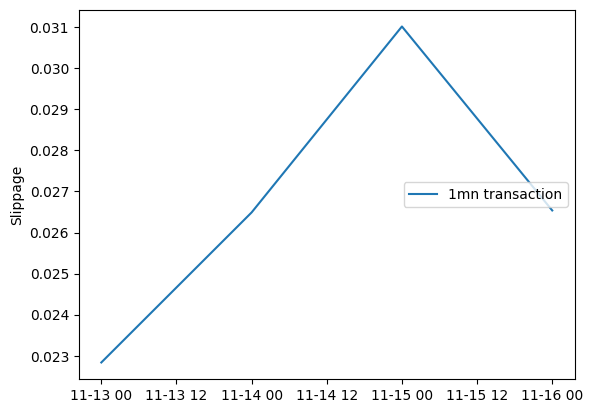

In [78]:

#Curve v2, 2-token pool
N_COINS = 2
ADJ_C = 1e18 #10**18

def delta_x_newtohRaphson(x0:int, y0:int , delta_y:int, A, gamma, D, S_t):
    """
    Calculating delta_x for buying delta_y using netwon-raphon method, x0 and y0 are token reserves in the pool, 
    A, gamma, D - parameters of the Curve v2 pool with 2 tokens
    """
    if A == 0 : # When A=0 the formula simplifies to Uniswap v2
        k = ((D/2)**2)
        y1 = y0 - delta_y #a trader buys delta_y so the reservers are getting smaller
        x1 = k / y1 
        delta_x = x1 - x0 
        #delta_x /= ADJ_C
        return (delta_x)
    
    ANN = A * N_COINS ** N_COINS
    ANN *= A_MULTIPLIER #this is an assumption of the code of Curve v2
    i = 0 #the firs token's reserver are unknows

    days = D.size
    #delta_x = np.zeros(days, dtype=np.uint64)

    delta_x = np.copy(y0)
    for j in range(days):
        print(j)

        x = [x0, (y0[j]-delta_y)/S_t[j]]
        xx = [x0, y0[j]/S_t[j]]

        Ds = solve_D(ANN, gamma, xx)
        print(Ds)
        nD = newton_D(ANN, gamma, xx, Ds)
        print("D=",D[j])
        #print("nD=",nD)
        x1:int = newton_y(ANN, gamma, x, Ds, i) #newton_y(ANN, gamma, x, nD, i)
        #x1:int = newton_y(ANN, gamma, x, D[j], i)
        #print("x0=",x0)
        #print("x1=",x1)
        
        dx:int = x1 - x0
        print("dx=",dx)
    
        delta_x[j] = dx
    return (delta_x)
    
def slippage_2token_curve_v2(S_t, S_0, delta_y, N_0, A, gamma):
    """
    Calculating slippage at Curve v2 in 2 token pool, based on the spot exchange rates S_t 
    """

    N_0 *= ADJ_C #some magic for compatiablity newthon method in Curve smart contract
    delta_y_adj = delta_y * ADJ_C    #some magic for compatiablity newthon method in Curve smart contract

    x0 = N_0  #initial reservers of CHF
    y0 = N_0 * S_t #initial reservers of EUR
    D = 2 * N_0 * (S_t) ** 0.5 
    #D = x0 + y0

    print("hello1")
    delta_x_adj = delta_x_newtohRaphson(x0, y0, delta_y_adj, A, gamma, D, S_t)
    print("hello2")
    tradePrice =  delta_y_adj / delta_x_adj
    print(tradePrice)
    print(S_t)
    #slippage = 1 - tradePrice / S_t
    slippage = (delta_x_adj * S_t - delta_y_adj) / (delta_x_adj * S_t)
    return (slippage)


#A = 0.05
#gamma = 0.000000011 * ADJ_C

A = 50
gamma = int(7e-5 * 1e18) # 0.000001 * ADJ_C

S_0 = fx.Close[0]
N_0 = 100_000_000 #reserve pool of CHF 
delta_y1 = 1_000_000 # a trader buy this amount of EUR
delta_y2 = 5_000_000


v_slippage_y1=slippage_2token_curve_v2(S_t=fx.Close.to_numpy(),S_0=S_0,delta_y=delta_y1,N_0=N_0, A=A, gamma=gamma)
v_slippage_y2=slippage_2token_curve_v2(S_t=fx.Close.to_numpy(),S_0=S_0,delta_y=delta_y2,N_0=N_0, A=A, gamma=gamma)

plt.plot(fx.Date, v_slippage_y1, label="1mn transaction")
plt.plot(fx.Date, v_slippage_y2, label="5mn transaction")
plt.legend(loc="center right")
plt.ylabel("Slippage")
